In [ ]:
!pip install -q nltk seaborn textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
import json
import math
from collections import Counter

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import textstat
import time

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

stop_words = set(stopwords.words("english"))

function_words = set([
    "the", "and", "to", "of", "in", "that", "is", "it", "for", "on",
    "with", "as", "was", "at", "by", "an", "be", "this", "from"
])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
data = []
paths = ["train.jsonl", "val.jsonl"]

for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                data.append({"text": obj["text"], "label": obj["label"]})
            except:
                continue

df = pd.DataFrame(data)
print("Loaded samples:", len(df))
print(df["label"].value_counts())
df.head()

Loaded samples: 27296
label
1    16918
0    10378
Name: count, dtype: int64


,text,label
0,"Duke Ellington, a titan of jazz, revolutionize...",1
1,I reflected on the shifting dynamics of media ...,1
2,"In F. Scott Fitzgerald's ""The Great Gatsby,"" t...",1
3,I still chuckle when I think about that time I...,1
4,"Yoga, originating in ancient India, encompasse...",1


In [ ]:
df_human = df[df["label"] == 0]
df_machine = df[df["label"] == 1].sample(len(df_human), random_state=42)

df_balanced = pd.concat([df_human, df_machine], ignore_index=True).sample(frac=1, random_state=42)

print(df_balanced.label.value_counts())
df_balanced.head()

label
0    10378
1    10378
Name: count, dtype: int64


,text,label
10317,In order to accomplish the goals outlined in t...,0
4074,But Lionel's note never reached Edith West. Wh...,0
9060,The Bible as the infallible word of God does n...,0
11286,The streets of Arcis hummed with the anticipat...,1
8254,In Their Own Words: The 43 Republicans’ Explan...,0


In [ ]:
features = []
readability_scores = []
entropy_values = []

for text in df_balanced["text"]:
    text = text.strip()

    # WORDS
    words = word_tokenize(text)
    word_count = len(words)
    unique_words = set(words)
    unique_word_count = len(unique_words)

    # Hapax
    freq = pd.Series(words).value_counts()
    hapax_rate = (freq == 1).sum() / word_count if word_count else 0

    # Sentences
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    avg_sentence_length = word_count / sentence_count if sentence_count else 0

    # Stopwords + Function words
    stopword_count = sum(1 for w in words if w.lower() in stop_words)
    functionword_count = sum(1 for w in words if w.lower() in function_words)
    function_word_ratio = functionword_count / word_count if word_count else 0

    # lexical
    ttr = unique_word_count / word_count if word_count else 0

    # punctuation + char-level
    punctuation_count = sum(1 for c in text if c in ".,!?;:-")
    punctuation_ratio = punctuation_count / len(text) if len(text) else 0

    comma_count = text.count(",")
    period_count = text.count(".")
    question_mark_count = text.count("?")
    exclamation_count = text.count("!")
    digit_ratio = sum(1 for c in text if c.isdigit()) / len(text) if len(text) else 0
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) else 0

    avg_word_length = np.mean([len(w) for w in words]) if word_count else 0

    # POS tagging
    pos_tags = pos_tag(words)
    noun_count = sum(1 for w,p in pos_tags if p.startswith("NN"))
    verb_count = sum(1 for w,p in pos_tags if p.startswith("VB"))
    adj_count = sum(1 for w,p in pos_tags if p.startswith("JJ"))

    noun_ratio = noun_count / word_count if word_count else 0
    verb_ratio = verb_count / word_count if word_count else 0
    adj_ratio = adj_count / word_count if word_count else 0

    # Bigrams
    bigrams = list(zip(words[:-1], words[1:]))
    bigram_uniqueness = len(set(bigrams))

    # Lexical density
    lexical_density = (noun_count + verb_count + adj_count) / word_count if word_count else 0

    # Readability
    try:
        readability = textstat.flesch_reading_ease(text)
    except:
        readability = 0

    # Entropy
    if len(text) > 0:
        counts = Counter(text)
        total = len(text)
        entropy = -sum((c/total) * math.log2(c/total) for c in counts.values())
    else:
        entropy = 0

    readability_scores.append(readability)
    entropy_values.append(entropy)

    features.append([
        word_count, unique_word_count, hapax_rate, ttr, avg_word_length,
        sentence_count, avg_sentence_length, stopword_count, functionword_count,
        function_word_ratio, punctuation_count, punctuation_ratio,
        comma_count, period_count, question_mark_count, exclamation_count,
        digit_ratio, uppercase_ratio, noun_ratio, verb_ratio,
        adj_ratio, bigram_uniqueness, lexical_density
    ])

In [ ]:
columns = [
    "word_count", "unique_word_count", "hapax_rate", "ttr", "avg_word_length",
    "sentence_count", "avg_sentence_length", "stopword_count", "functionword_count",
    "function_word_ratio", "punctuation_count", "punctuation_ratio",
    "comma_count", "period_count", "question_mark_count", "exclamation_count",
    "digit_ratio", "uppercase_ratio", "noun_ratio", "verb_ratio",
    "adj_ratio", "bigram_uniqueness", "lexical_density"
]

feature_df = pd.DataFrame(features, columns=columns)

feature_df["readability_score"] = readability_scores
feature_df["entropy"] = entropy_values
feature_df["label"] = df_balanced["label"]
feature_df["label_name"] = feature_df["label"].map({0: "Human", 1: "Machine"})

feature_df.head()

,word_count,unique_word_count,hapax_rate,ttr,avg_word_length,sentence_count,avg_sentence_length,stopword_count,functionword_count,function_word_ratio,...,uppercase_ratio,noun_ratio,verb_ratio,adj_ratio,bigram_uniqueness,lexical_density,readability_score,entropy,label,label_name
0,561,231,0.276292,0.411765,4.556150,23,24.391304,242,186,0.331551,...,0.035831,0.322638,0.137255,0.055258,409,0.515152,44.259053,4.413136,0,Human
1,873,384,0.318442,0.439863,3.880871,35,24.942857,396,202,0.231386,...,0.015523,0.195876,0.137457,0.081329,783,0.414662,67.862363,4.328977,0,Human
2,778,350,0.318766,0.449871,4.245501,28,27.785714,318,194,0.249357,...,0.019697,0.275064,0.145244,0.059126,702,0.479434,54.079332,4.466795,0,Human
3,806,419,0.437965,0.519851,4.514888,29,27.793103,296,184,0.228288,...,0.013426,0.276675,0.115385,0.058313,741,0.450372,43.514017,4.341810,0,Human
4,403,207,0.357320,0.513648,4.369727,13,31.000000,167,97,0.240695,...,0.027423,0.280397,0.124069,0.071960,349,0.476427,45.699385,4.428655,0,Human


In [ ]:
X = feature_df.drop(["label", "label_name"], axis=1)
y = feature_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = []
times = []

for name, model in models.items():
    print("Training:", name)
    start = time.time()
    model.fit(X_train_s, y_train)
    end = time.time()

    preds = model.predict(X_test_s)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="binary"
    )
    acc = accuracy_score(y_test, preds)

    results.append([name, acc, precision, recall, f1])
    times.append([name, end - start])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
times_df = pd.DataFrame(times, columns=["Model", "Train_Time"])

results_df, times_df

Training: Logistic Regression
Training: Linear SVM
Training: Random Forest
Training: Gradient Boosting


(                 Model  Accuracy  Precision    Recall        F1
 0  Logistic Regression  0.490607   0.490076  0.463873  0.476615
 1           Linear SVM  0.490125   0.489599  0.464836  0.476896
 2        Random Forest  0.499277   0.499250  0.481214  0.490066
 3    Gradient Boosting  0.499277   0.499280  0.500963  0.500120,
                  Model  Train_Time
 0  Logistic Regression    0.091471
 1           Linear SVM    0.182842
 2        Random Forest   28.051624
 3    Gradient Boosting   14.187318)

/tmp/ipython-input-4136952775.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=times_df, x="Model", y="Train_Time", palette="viridis")


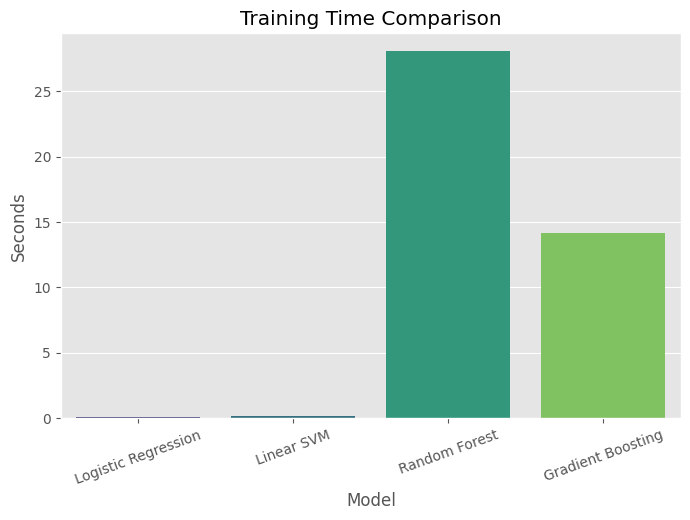

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=times_df, x="Model", y="Train_Time", palette="viridis")
plt.title("Training Time Comparison")
plt.xticks(rotation=20)
plt.ylabel("Seconds")
plt.show()

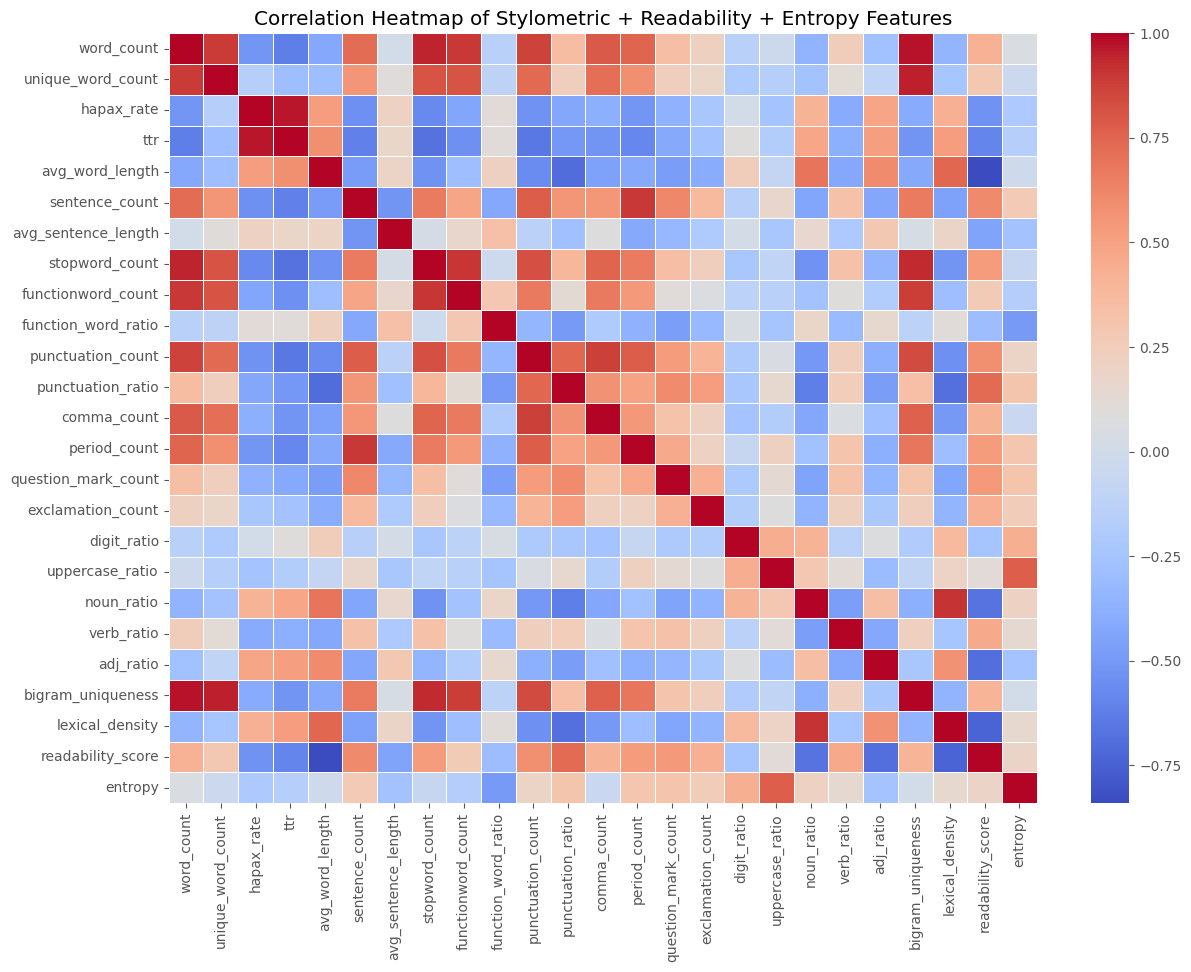

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(
    feature_df.drop(columns=["label", "label_name"]).corr(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Stylometric + Readability + Entropy Features")
plt.show()

/tmp/ipython-input-2317457855.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="label_name", y="readability_score", palette="Set2")


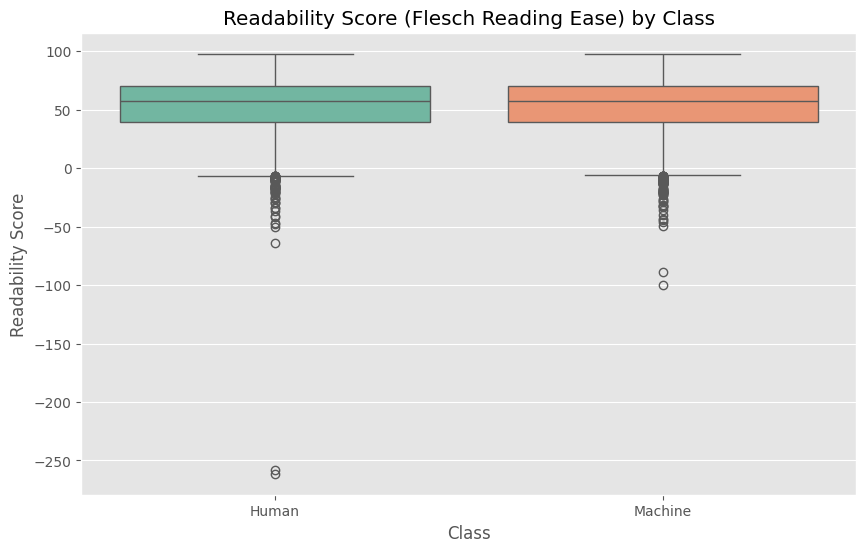

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=feature_df, x="label_name", y="readability_score", palette="Set2")
plt.title("Readability Score (Flesch Reading Ease) by Class")
plt.xlabel("Class")
plt.ylabel("Readability Score")
plt.show()

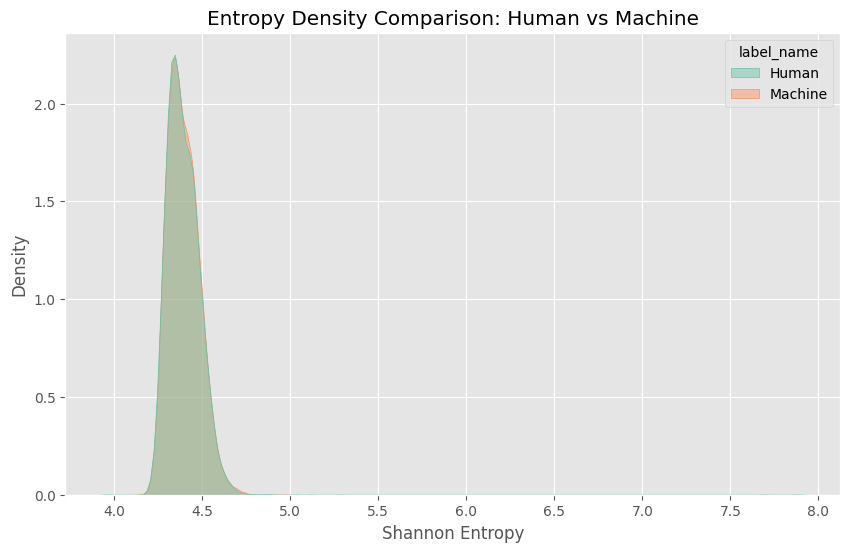

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=feature_df, x="entropy", hue="label_name", fill=True, alpha=0.45)
plt.title("Entropy Density Comparison: Human vs Machine")
plt.xlabel("Shannon Entropy")
plt.ylabel("Density")
plt.show()

In [ ]:
feature_df["label_name"] = feature_df["label"].map({0: "Human", 1: "Machine"})

print(feature_df.columns.tolist())
feature_df.head()

['word_count', 'unique_word_count', 'hapax_rate', 'ttr', 'avg_word_length', 'sentence_count', 'avg_sentence_length', 'stopword_count', 'functionword_count', 'function_word_ratio', 'punctuation_count', 'punctuation_ratio', 'comma_count', 'period_count', 'question_mark_count', 'exclamation_count', 'digit_ratio', 'uppercase_ratio', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'bigram_uniqueness', 'lexical_density', 'readability_score', 'entropy', 'label', 'label_name']


,word_count,unique_word_count,hapax_rate,ttr,avg_word_length,sentence_count,avg_sentence_length,stopword_count,functionword_count,function_word_ratio,...,uppercase_ratio,noun_ratio,verb_ratio,adj_ratio,bigram_uniqueness,lexical_density,readability_score,entropy,label,label_name
0,561,231,0.276292,0.411765,4.556150,23,24.391304,242,186,0.331551,...,0.035831,0.322638,0.137255,0.055258,409,0.515152,44.259053,4.413136,0,Human
1,873,384,0.318442,0.439863,3.880871,35,24.942857,396,202,0.231386,...,0.015523,0.195876,0.137457,0.081329,783,0.414662,67.862363,4.328977,0,Human
2,778,350,0.318766,0.449871,4.245501,28,27.785714,318,194,0.249357,...,0.019697,0.275064,0.145244,0.059126,702,0.479434,54.079332,4.466795,0,Human
3,806,419,0.437965,0.519851,4.514888,29,27.793103,296,184,0.228288,...,0.013426,0.276675,0.115385,0.058313,741,0.450372,43.514017,4.341810,0,Human
4,403,207,0.357320,0.513648,4.369727,13,31.000000,167,97,0.240695,...,0.027423,0.280397,0.124069,0.071960,349,0.476427,45.699385,4.428655,0,Human


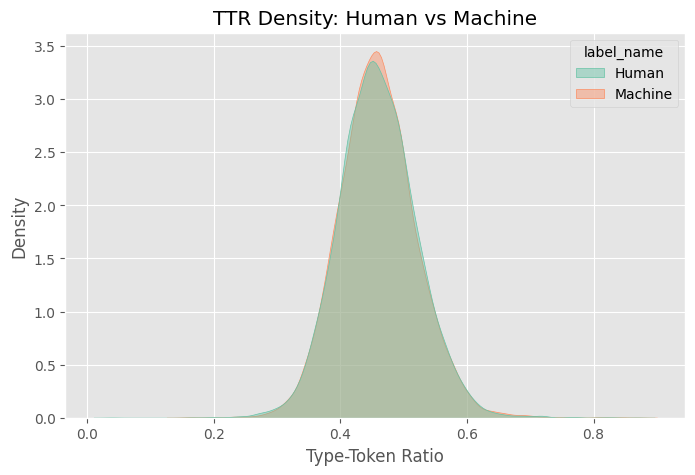

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=feature_df, x="ttr", hue="label_name", fill=True, alpha=0.45)
plt.title("TTR Density: Human vs Machine")
plt.xlabel("Type-Token Ratio")
plt.ylabel("Density")
plt.show()

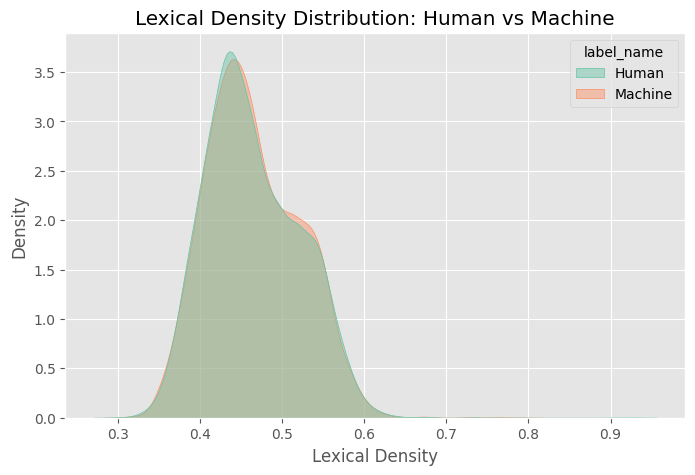

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=feature_df, x="lexical_density", hue="label_name", fill=True, alpha=0.45)
plt.title("Lexical Density Distribution: Human vs Machine")
plt.xlabel("Lexical Density")
plt.ylabel("Density")
plt.show()


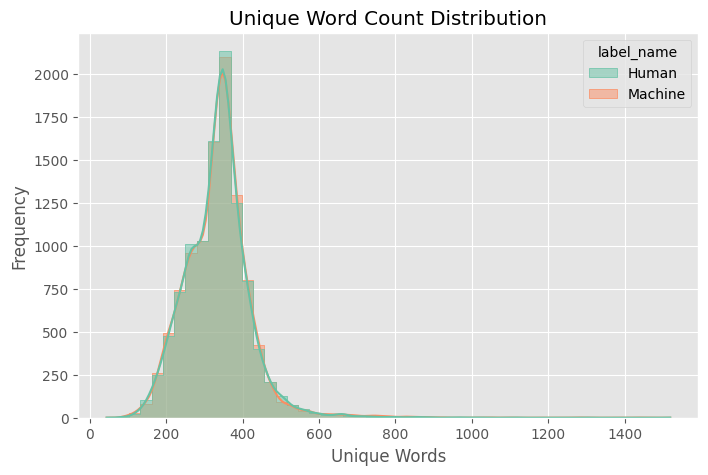

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=feature_df,
    x="unique_word_count",
    hue="label_name",
    bins=50,
    kde=True,
    element="step",
    alpha=0.5
)
plt.title("Unique Word Count Distribution")
plt.xlabel("Unique Words")
plt.ylabel("Frequency")
plt.show()

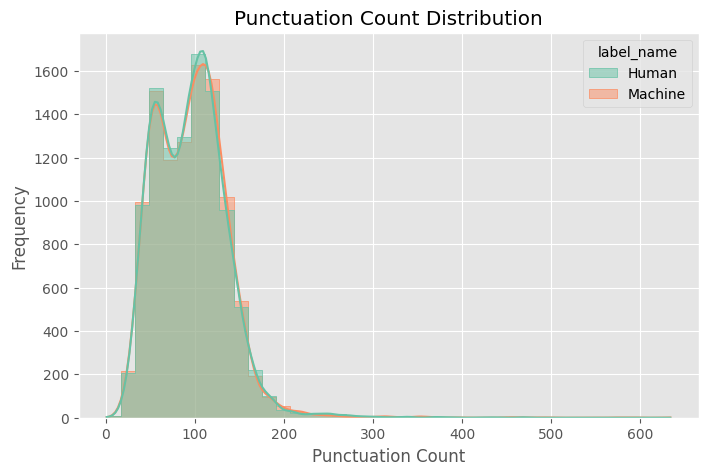

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=feature_df,
    x="punctuation_count",
    hue="label_name",
    bins=40,
    kde=True,
    element="step",
    alpha=0.5
)
plt.title("Punctuation Count Distribution")
plt.xlabel("Punctuation Count")
plt.ylabel("Frequency")
plt.show()

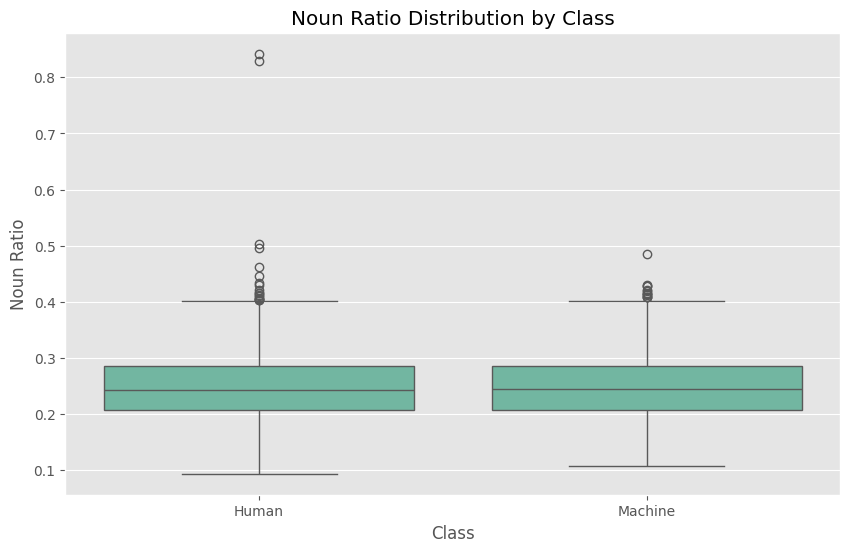

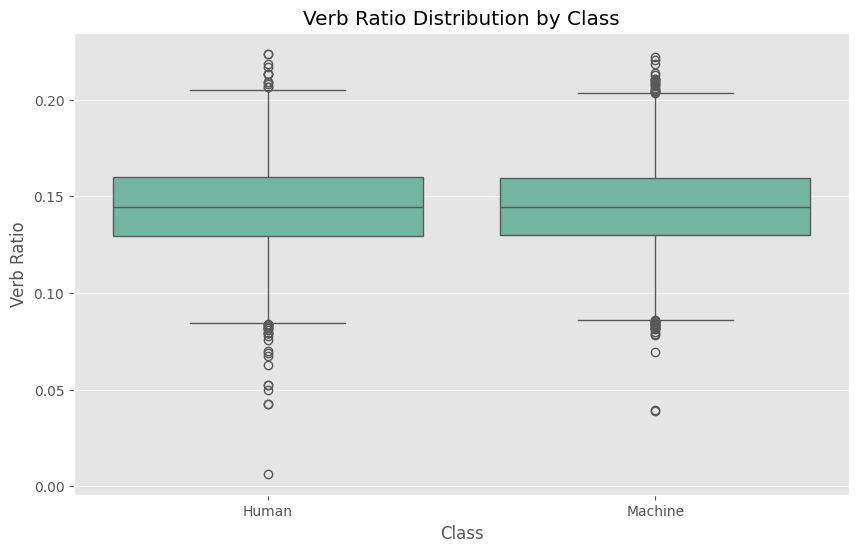

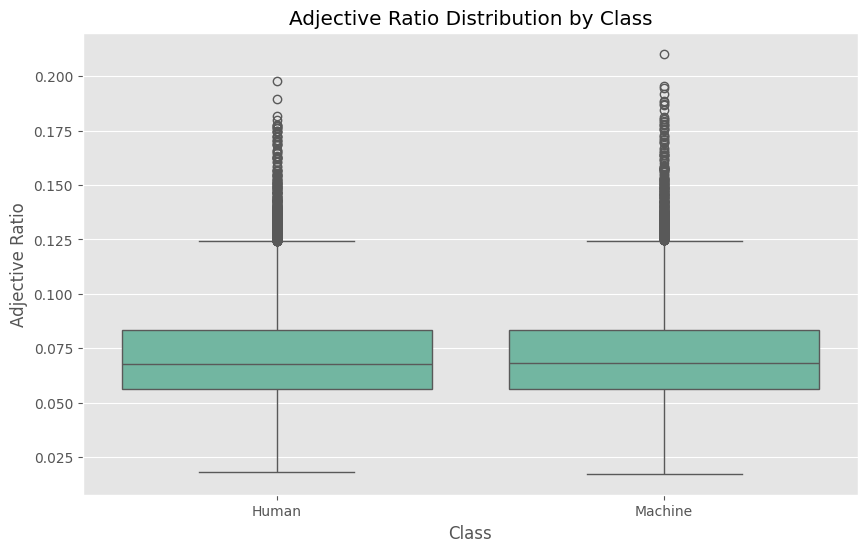

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=feature_df, x="label_name", y="noun_ratio")
plt.title("Noun Ratio Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Noun Ratio")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=feature_df, x="label_name", y="verb_ratio")
plt.title("Verb Ratio Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Verb Ratio")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=feature_df, x="label_name", y="adj_ratio")
plt.title("Adjective Ratio Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Adjective Ratio")
plt.show()


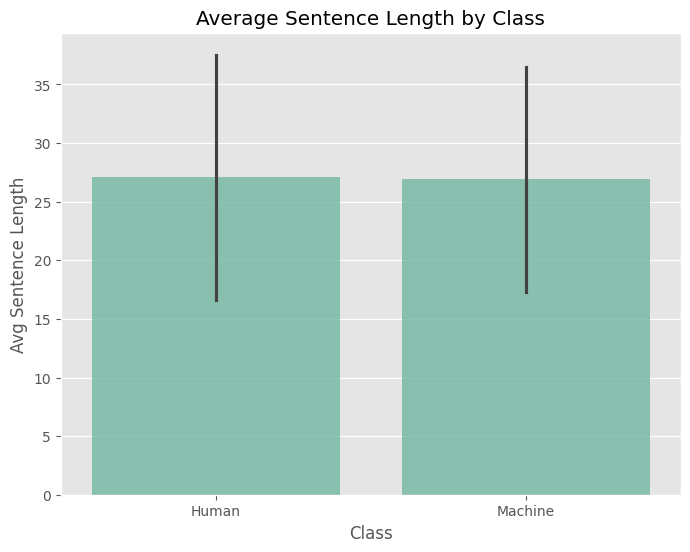

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=feature_df,
    x="label_name",
    y="avg_sentence_length",
    errorbar="sd",
    alpha=0.8
)
plt.title("Average Sentence Length by Class")
plt.xlabel("Class")
plt.ylabel("Avg Sentence Length")
plt.show()

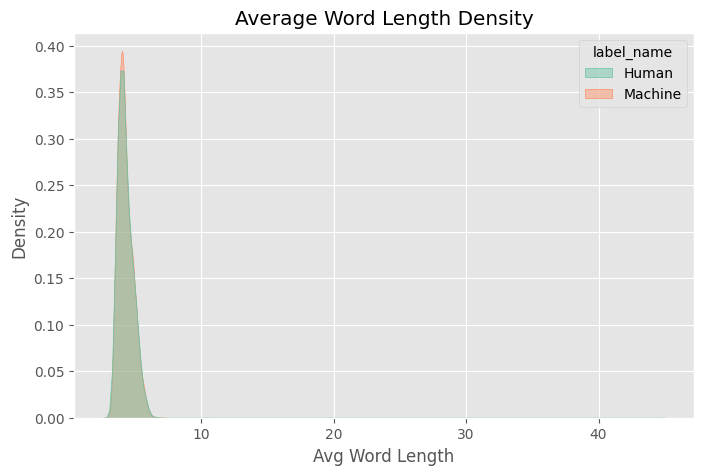

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=feature_df, x="avg_word_length", hue="label_name", fill=True, alpha=0.45)
plt.title("Average Word Length Density")
plt.xlabel("Avg Word Length")
plt.ylabel("Density")
plt.show()

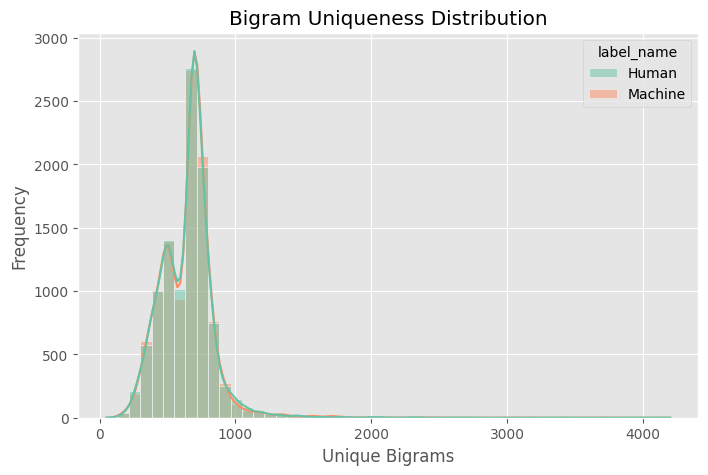

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=feature_df,
    x="bigram_uniqueness",
    hue="label_name",
    bins=50,
    kde=True,
    alpha=0.5
)
plt.title("Bigram Uniqueness Distribution")
plt.xlabel("Unique Bigrams")
plt.ylabel("Frequency")
plt.show()